---
syncID: e046a83d83f2042d8b40dea1b20fd6779
title: "Read in and visualize hyperspectral data in Python using functions"
description: "Learn to efficiently work with tiled NEON AOP hyperspectral data in Python using functions."
dateCreated: 2017-06-19 
authors: Bridget Hass
contributors: Tristan Goulden
estimatedTime: 1 hour
packagesLibraries: h5py, requests, skikit-image, neonutilities, pandas, python-dotenv
topics: hyperspectral, remote-sensing, hdf5
languagesTool: Python
dataProduct: NEON.DP3.30006.001, NEON.DP3.30006.002
code1: https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/tutorials/Python/AOP/Hyperspectral/intro-hyperspectral/hyperspectral_functions/intro_hyperspectral_functions.ipynb
tutorialSeries: 
urlTitle: refl-functions-py
---

In this tutorial, you will learn how to efficiently read in hdf5 reflectance data and metadata, plot a single band and Red-Green-Blue (RGB) band combinations of a reflectance data tile using Python functions created for working with and visualizing NEON AOP hyperspectral data.

This tutorial uses the Level 3 <a href="https://data.neonscience.org/data-products/DP3.30006.002" target="_blank">Spectrometer orthorectified surface bidirectional reflectance - mosaic</a> data product. 


<div id="ds-objectives" markdown="1">


### Learning Objectives

After completing this tutorial, you will be able to:

* Work with custom Python modules and functions for AOP data
* Download and read in tiled NEON AOP reflectance hdf5 data and associated metadata
* Plot a single band of reflectance data
* Stack and plot 3-band combinations to visualize true color and false color images

### Install Python Packages

* **h5py**
* **gdal**
* **neonutilities**
* **pandas**
* **python-dotenv**
* **requests**
* **scikit-image**

### Data

Data and additional scripts required for this lesson are downloaded programmatically as part of the tutorial.

The data used in this lesson were collected over NEON's
<a href="https://www.neonscience.org/field-sites/dsny" target="_blank">Disney Wilderness Preserve (DSNY)</a> field site and processed at NEON headquarters.

The dataset can also be downloaded from the <a href="http://data.neonscience.org" target="_blank">NEON Data Portal</a>.

### Requirements

Set up a **NEON user account and token**, if you haven't already done so. Follow the tutorial below to learn how to do this (check the Python tabs in the code cells for the Python syntax.

<a href="https://www.neonscience.org/resources/learning-hub/tutorials/neon-api-tokens-tutorial" target="_blank">Using an API Token when Accessing NEON Data with neonUtilities</a>. 

Note: for this tutorial, we have set up the token as an environment variable, following "Option 2: Set token as environment variable" in the linked lesson.

### Recommended Resources
If you are new to AOP hyperspectral data, we recommend exploring the following tutorial series:

<a href="https://www.neonscience.org/resources/learning-hub/tutorials/introduction-hyperspectral-remote-sensing-data-python" target="_blank">Introduction to Hyperspectral Remote Sensing Data in Python</a>

</div>

## Background

We can combine any three bands from the NEON reflectance data to make an RGB image that will depict different information about the Earth's surface. A **natural color** image, made with bands from the red, green, and blue wavelengths looks close to what we would see with the naked eye. We can also choose band combinations from other wavelenghts, and map them to the red, blue, and green colors to highlight different features. A **false color** image is made with one or more bands from a non-visible portion of the electromagnetic spectrum that are mapped to red, green, and blue colors. These images can display other information about the landscape that is not easily seen with a natural color image. 

The NASA Goddard Media Studio video "Peeling Back Landsat's Layers of Data" gives a good quick overview of natural and false color band combinations. Note that the Landsat multispectral sensor collects information from 11 bands, while NEON AOP hyperspectral data captures information spanning 426 bands!

### Peeling Back Landsat's Layers of Data Video

<iframe width="560" height="315" src="https://www.youtube.com/embed/YP0et8l_bvY" frameborder="0" allowfullscreen></iframe>


### Further Reading

* Check out the NASA Earth Observatory article 
<a href="https://earthobservatory.nasa.gov/Features/FalseColor/" target="_blank">How to Interpret a False-Color Satellite Image</a>. 
* Read the supporting article for the video above, 
<a href="https://svs.gsfc.nasa.gov//vis/a010000/a011400/a011491/index.html" target="_blank"> Landsat 8 Onion Skin</a>. 


## Load Function Module

First, import the required packages and the `neon_aop_hyperspectral` module, which includes functions that we will use to read in and visualize the hyperspectral hdf5 data.

In [1]:
import dotenv
import h5py
import matplotlib.pyplot as plt
import neonutilities as nu
import numpy as np
import os
import requests
import sys
import time

This next function is a handy way to download the Python module that we will be use in this lesson. This uses the `requests` package.

In [2]:
# function to download data stored on the internet in a public url to a local file
def download_url(url,download_dir):
    if not os.path.isdir(download_dir):
        os.makedirs(download_dir)
    filename = url.split('/')[-1]
    r = requests.get(url, allow_redirects=True)
    file_object = open(os.path.join(download_dir,filename),'wb')
    file_object.write(r.content)

Download the module from its location on GitHub, add the `../python_modules` directory to the path and import the `neon_aop_hyperspectral.py` module as `neon_hs`.

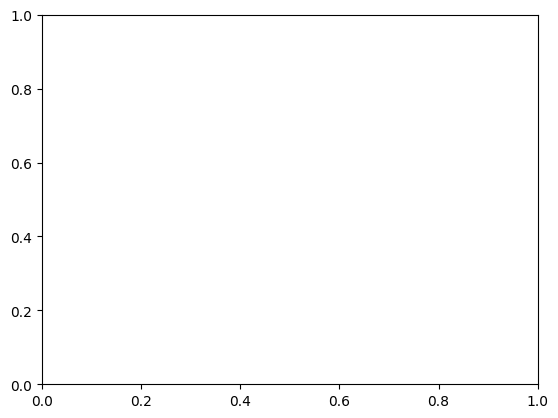

In [3]:
module_url = "https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/tutorials/Python/AOP/aop_python_modules/neon_aop_hyperspectral.py"
download_url(module_url,'../python_modules')
# os.listdir('../python_modules') #optionally show the contents of this directory to confirm the file downloaded

sys.path.insert(0, '../python_modules')
# import the neon_aop_hyperspectral module
import neon_aop_hyperspectral as neon_hs

The first function we will use is `aop_h5refl2array`. We encourage you to look through the code to understand what it is doing behind the scenes. This function automates the steps required to read AOP hdf5 reflectance files into a Python numpy array. This function also cleans the data: it sets any no data values within the reflectance tile to `nan` (not a number) and applies the reflectance scale factor so the final array that is returned represents unitless scaled reflectance, with values ranging between 0 and 1 (0-100%). 

**Data Tip:** If you forget the inputs to a function or want to see more details on what the function does, you can use `help()` or `?` to display the associated docstrings. 

In [4]:
help(neon_hs.aop_h5refl2array)
# neon_hs.aop_h5refl2array? #uncomment for an alternate way to show the help

Help on function aop_h5refl2array in module neon_aop_hyperspectral:

aop_h5refl2array(h5_filename, raster_type_: Literal['Cast_Shadow', 'Data_Selection_Index', 'GLT_Data', 'Haze_Cloud_Water_Map', 'IGM_Data', 'Illumination_Factor', 'OBS_Data', 'Radiance', 'Reflectance', 'Sky_View_Factor', 'to-sensor_Azimuth_Angle', 'to-sensor_Zenith_Angle', 'Visibility_Index_Map', 'Weather_Quality_Indicator'], only_metadata=False)
    read in NEON AOP reflectance hdf5 file and return the un-scaled 
    reflectance array, associated metadata, and wavelengths
           
    Parameters
    ----------
        h5_filename : string
            reflectance hdf5 file name, including full or relative path
        raster : string
            name of raster value to read in; this will typically be the reflectance data, 
            but other data stored in the h5 file can be accessed as well
            valid options: 
                Cast_Shadow (ATCOR input)
                Data_Selection_Index
                

Now that we have an idea of how this function works, let's try it out. First, we need to download a reflectance file. We can download a single 1 km x 1 km reflectance data tile for the DSNY site using the `neonutilities` `by_tile_aop` function as shown below. This downloads to a data folder specified in `savepath`. Before downloading a tile, let's take a quick look at when data were collected (and are avaiable) at this site using the `list_available_dates` function.

In [5]:
# display dates of available data for the directional and bidirectional reflectance data at DNSY
print('Directional reflectance data availability:')
nu.list_available_dates('DP3.30006.001','DSNY') # directional reflectance data ends with .001
print('\nBidirectional reflectance data availability:')
nu.list_available_dates('DP3.30006.002','DSNY') # BRDF and topographic corrected reflectance data ends with .002

Directional reflectance data availability:


RELEASE-2025 Available Dates: 2014-05, 2016-09, 2017-09, 2018-10, 2019-04, 2021-09
PROVISIONAL Available Dates: 2023-04



Bidirectional reflectance data availability:


Next we can also look at the tile extents so we can roughly determine the valid values to enter for the easting and northing, which are input parameters to the `by_tile_aop` function. First, let's set our NEON token as follows:

dotenv.set_key(dotenv_path=".env",
key_to_set="NEON_TOKEN",
value_to_set="YOUR_TOKEN_HERE")

In [6]:
dotenv.load_dotenv()
my_token=os.environ.get("NEON_TOKEN")
# optionally display the token to double check
# print('my token: ',my_token)

In [7]:
dsny_bounds = nu.get_aop_tile_extents('DP3.30006.002','DSNY','2023',token=my_token)

Easting Bounds: (451000, 464000)
Northing Bounds: (3099000, 3114000)


In [8]:
# display the first and last UTM coordinates of the DSNY site:
print('First 3 coordinates:\n',dsny_bounds[:3])
print('Last 3 coordinates:\n',dsny_bounds[-3:])

First 3 coordinates:
 [(451000, 3103000), (451000, 3104000), (451000, 3105000)]
Last 3 coordinates:
 [(463000, 3112000), (464000, 3108000), (464000, 3111000)]


Set up the data directory where we want to download our data. 

**Data Tip**: If are working from a Windows Operating System (OS), there may be a path length limitation which might cause an error in downloading, since the neon download function maintains the full folder structure the data, as it is stored on Google Cloud Storage (GCS). If you see the following warning: "`UserWarning: Filepaths on Windows are limited to 260 characters. Attempting to download a filepath that is 291 characters long. Set the working or savepath directory to be closer to the root directory or enable long path support in Windows.`", you will either need to enable long path support in Windows (a quick online search will show you how to do this) or set the `savepath` directory so that it is shorter. You can use `os.path.abspath` to see the full path, if you have specified a relative path. For this example, we will set a short `savepath` by creating a `neon_data` directly directly under the home directory as follows:

In [9]:
home_dir = os.path.expanduser('~')
data_dir = os.path.join(home_dir,'neon_data')
# optionally display the full path to the data_dir as follows:
# os.path.abspath(data_dir)

In [10]:
nu.by_tile_aop(dpid='DP3.30006.002',
               site='DSNY',
               year='2023',
               easting=454000,
               northing=3113000,
               include_provisional=True,
               savepath=data_dir,
               token=my_token)

Provisional NEON data are included. To exclude provisional data, use input parameter include_provisional=False.


Continuing will download 2 NEON data files totaling approximately 713.3 MB. Do you want to proceed? (y/n)  n


Download halted


In [11]:
def list_data_subfolders(data_dir):
    """
    Recursively finds and lists subfolders within a directory that contain data (files)
    and excludes subfolders that only contain other subfolders.

    Args:
        data_dir: The path to the root directory to search.

    Returns:
        A list of paths to the subfolders containing data.
    """
    data_subfolders = []
    for root, dirs, files in os.walk(data_dir):
        # Check if the current directory has both subdirectories and files
        if dirs and files:
            # Iterate through subdirectories to find those that contain files
            for dir_name in dirs:
                dir_path = os.path.join(root, dir_name)
                if any(os.path.isfile(os.path.join(dir_path, f)) for f in os.listdir(dir_path)):
                    data_subfolders.append(dir_path)
        # If the current directory has no subdirectories, but has files, we still want to keep the directory.
        elif files:
            if root != data_dir:  # Avoid adding the root directory itself if it has files
                data_subfolders.append(root)

    return data_subfolders

def list_data_files(data_dir):
    """
    Lists all files within a specified directory and its subdirectories.

    Args:
        data_dir (str): The path to the data directory to start the search from.

    Returns:
        list: A list of full paths to all files found.
    """
    all_files = []
    for root, _, files in os.walk(data_dir):
        for file in files:
            full_path = os.path.join(root, file)
            all_files.append(full_path)
    return all_files

We can use these functions to explore the contents of the data that were downloaded. You can also go into File Explorer (Windows) or Finder (Mac) to explore the contents in a more interactive way.

In [12]:
neon_data_subfolders = list_data_subfolders(data_dir)
# display the paths starting with `neon_data` to shorten:
neon_subfolders_short = [f.replace(home_dir,'') for f in neon_data_subfolders]
neon_subfolders_short

['\\neon_data\\DP3.30006.002\\neon-aop-provisional-products\\2023\\FullSite\\D03\\2023_DSNY_7\\L3\\Spectrometer\\Reflectance',
 '\\neon_data\\DP3.30006.002\\neon-publication\\NEON.DOM.SITE.DP3.30006.002\\DSNY\\20230401T000000--20230501T000000\\basic']

Data were downloaded into two nested subfolders. The reflectance data is saved in the path `2023\FullSite\D03\2023_DSNY_7\L3\Spectrometer\Reflectance`. This is the standard format where you can expect to find L3 data. Note that before 2023 there is a `neon-aop-provisional-products` folder. This is because the DSNY data from 2023 is available provisionally. If the data were released, it would be found under `neon-aop-products`. 

Next let's use the `list_data_files` function to see the actual files that we downloaded. If you included a larger range of points in the Easting and Northing, or used `by_file_aop`, this list could be much longer.

In [13]:
downloaded_refl_files = list_data_files(data_dir)
# display the files starting with `neon_data` to shorten:
downloaded_refl_files_short = [f.replace(home_dir,'') for f in downloaded_refl_files]
downloaded_refl_files_short

['\\neon_data\\DP3.30006.002\\citation_DP3.30006.002_PROVISIONAL.txt',
 '\\neon_data\\DP3.30006.002\\issueLog_DP3.30006.002.csv',
 '\\neon_data\\DP3.30006.002\\neon-aop-provisional-products\\2023\\FullSite\\D03\\2023_DSNY_7\\L3\\Spectrometer\\Reflectance\\NEON_D03_DSNY_DP3_454000_3113000_bidirectional_reflectance.h5',
 '\\neon_data\\DP3.30006.002\\neon-publication\\NEON.DOM.SITE.DP3.30006.002\\DSNY\\20230401T000000--20230501T000000\\basic\\NEON.D03.DSNY.DP3.30006.002.readme.20241220T001434Z.txt']

In [14]:
# read the h5 reflectance file (including the full path) to the variable h5_file_name
# h5_file_name = data_url.split('/')[-1]
h5_tiles = [f for f in downloaded_refl_files if f.endswith('.h5')]
h5_tile = h5_tiles[0]
# print(f'h5_tile: {h5_tile}')

Now that we've specified our reflectance tile, we can call `aop_h5refl2array` to read in the reflectance tile as a python array called `refl`, the metadata into a dictionary called `refl_metadata`, and the wavelengths into an array. Let's read it it and then take a quick look at the metadata and the first 5 wavelength values.

In [15]:
# read in the reflectance data using the aop_h5refl2array function, this may also take a bit of time
start_time = time.time()
refl, refl_metadata, wavelengths = neon_hs.aop_h5refl2array(h5_tile,'Reflectance')
print("--- It took %s seconds to read in the data ---" % round((time.time() - start_time),0))

Reading in  C:\Users\bhass\neon_data\DP3.30006.002\neon-aop-provisional-products\2023\FullSite\D03\2023_DSNY_7\L3\Spectrometer\Reflectance\NEON_D03_DSNY_DP3_454000_3113000_bidirectional_reflectance.h5
--- It took 23.0 seconds to read in the data ---


In [16]:
# display the reflectance metadata dictionary contents
refl_metadata

{'shape': (1000, 1000, 426),
 'no_data_value': -9999.0,
 'scale_factor': 10000.0,
 'bad_band_window1': array([1340, 1445]),
 'bad_band_window2': array([1790, 1955]),
 'projection': b'+proj=UTM +zone=17 +ellps=WGS84 +datum=WGS84 +units=m +no_defs',
 'EPSG': 32617,
 'res': {'pixelWidth': 1.0, 'pixelHeight': 1.0},
 'extent': (454000.0, 455000.0, 3113000.0, 3114000.0),
 'ext_dict': {'xMin': 454000.0,
  'xMax': 455000.0,
  'yMin': 3113000.0,
  'yMax': 3114000.0},
 'source': 'C:\\Users\\bhass\\neon_data\\DP3.30006.002\\neon-aop-provisional-products\\2023\\FullSite\\D03\\2023_DSNY_7\\L3\\Spectrometer\\Reflectance\\NEON_D03_DSNY_DP3_454000_3113000_bidirectional_reflectance.h5'}

In [17]:
# display the first 5 values of the wavelengths
wavelengths[:5]

array([383.884003, 388.891693, 393.899506, 398.907196, 403.915009])

We can use the `shape` method to see the dimensions of the array we read in. Use this method to confirm that the size of the reflectance array makes sense given the hyperspectral data cube, which is 1000 meters x 1000 meters x 426 bands.

In [18]:
refl.shape

(1000, 1000, 426)

## Plot a single band of the reflectance data using `plot_aop_refl`: 

Next we'll use the function `plot_aop_refl` to plot a single band of reflectance data. You can use `help` to understand the required inputs and data types for each of these; only the band and spatial extent are required inputs, the rest are optional inputs. If specified, these optional inputs allow you to set the range color values, specify the axis, add a title, colorbar, colorbar title, and change the colormap (default is to plot in greyscale). 

In [19]:
band56 = refl[:,:,55]

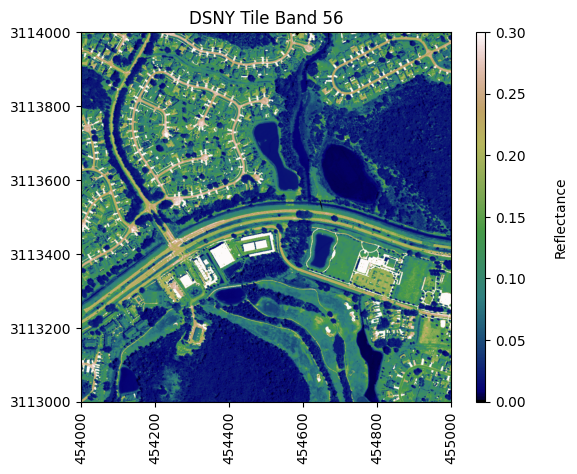

In [20]:
neon_hs.plot_aop_refl(band56/refl_metadata['scale_factor'],
                      refl_metadata['extent'],
                      colorlimit=(0,0.3),
                      title='DSNY Tile Band 56',
                      cmap_title='Reflectance',
                      colormap='gist_earth')

## RGB Plots - Band Stacking
It is often useful to look at several bands together. We can extract and stack three reflectance bands in the red, green, and blue (RGB) spectrums to produce a color image that looks like what we see with our eyes; this is your typical camera image. In the next part of this tutorial, we will learn to stack multiple bands and make a geotif raster from the compilation of these bands. We can see that different combinations of bands allow for different visualizations of the remotely-sensed objects and also conveys useful information about the chemical makeup of the Earth's surface. 

We will select bands that fall within the visible range of the electromagnetic spectrum (400-700 nm) and at specific points that correspond to what we see as red, green, and blue.

<figure>
	<a href="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/hyperspectral-general/spectrum_RGBcombined.png">
	<img src="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/hyperspectral-general/spectrum_RGBcombined.png" width = 600></a>
	<figcaption> NEON Imaging Spectrometer bands and their respective wavelengths. Source: National Ecological Observatory Network (NEON)  
	</figcaption>
</figure>

For this exercise, we'll first use the function `stack_rgb` to extract the bands we want to stack. This function uses splicing to extract the nth band from the reflectance array, and then uses the numpy function `stack` to create a new 3D array (1000 x 1000 x 3) consisting of only the three bands we want. 

In [21]:
# pull out the true-color band combinations
rgb_bands = (58,34,19) # set the red, green, and blue bands

# stack the 3-band combinations (rgb and cir) using stack_rgb function
rgb_unscaled = neon_hs.stack_rgb(refl,rgb_bands)

# apply the reflectance scale factor
rgb = rgb_unscaled/refl_metadata['scale_factor']

We can display the red, green, and blue band center wavelengths, whose indices were defined above. To confirm that these band indices correspond to wavelengths in the expected portion of the spectrum, we can print out the wavelength values in nanometers.

In [22]:
print('Center wavelengths:')
print('Band 58: %.1f' %(wavelengths[57]),'nm')
print('Band 33: %.1f' %(wavelengths[33]),'nm')
print('Band 19: %.1f' %(wavelengths[18]),'nm')

Center wavelengths:
Band 58: 669.3 nm
Band 33: 549.1 nm
Band 19: 474.0 nm


## Plot an RGB band combination using `plot_aop_rgb`: 

Next, we can use the function `plot_aop_rgb` to plot the band stack as follows:

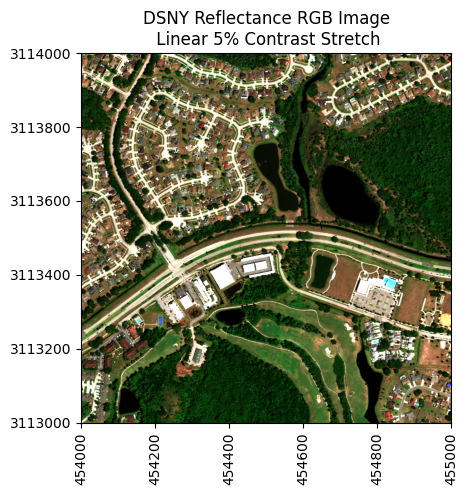

In [23]:
# plot the true color image (rgb)
neon_hs.plot_aop_rgb(rgb,
                     refl_metadata['extent'],
                     plot_title='DSNY Reflectance RGB Image')

## False Color Image - Color Infrared (CIR)
We can also create an image from bands outside of the visible spectrum. An image containing one or more bands outside of the visible range is called a **false-color image**. Here we'll use the green and blue bands as before, but we replace the red band with a near-infrared (NIR) band. 

For more information about non-visible wavelengths, false color images, and some frequently used false-color band combinations, refer to <a href="https://earthobservatory.nasa.gov/Features/FalseColor/" target="_blank">NASA's Earth Observatory page</a>.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0..32767].


Band 90 Center Wavelength = 829.6 nm
Band 34 Center Wavelength = 549.1 nm
Band 19 Center Wavelength = 474.0 nm


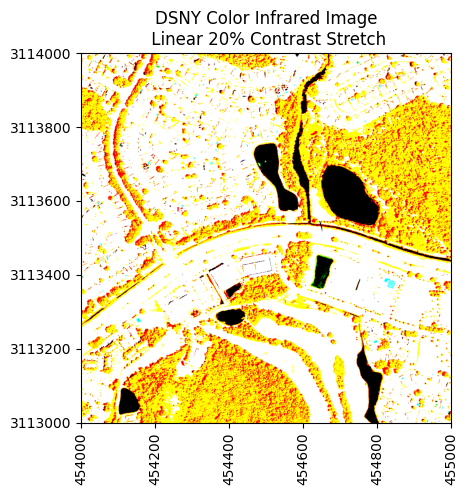

In [24]:
cir_bands = (90,34,19)
print('Band 90 Center Wavelength = %.1f' %(wavelengths[89]),'nm')
print('Band 34 Center Wavelength = %.1f' %(wavelengths[33]),'nm')
print('Band 19 Center Wavelength = %.1f' %(wavelengths[18]),'nm')

cir = neon_hs.stack_rgb(refl,cir_bands)
neon_hs.plot_aop_rgb(cir,
                     refl_metadata['extent'],
                     ls_pct=20,
                     plot_title='DSNY Color Infrared Image')

## Recap

Congratulations! You have successfully downloaded a NEON reflectance tile using the `neonutilities` `by_tile_aop` function. You have also pulled in some pre-defined functions and used these to read in and visualize the reflectance data. You are now well poised to start carrying out more in-depth analysis using the hyperspectral data with Python.

## References

Kekesi, Alex et al. 
<a href="https://www.youtube.com/watch?v=YP0et8l_bvY/" target="_blank"> "NASA | Peeling Back Landsat's Layers of Data"</a>. Published on Feb 24, 2014.

Riebeek, Holli. 
<a href="https://earthobservatory.nasa.gov/Features/FalseColor/" target="_blank"> "Why is that Forest Red and that Cloud Blue? How to Interpret a False-Color Satellite Image" </a>. Published on March 4, 2014.
